The other Notebook became a bit much, so I'll be working on visualisations in this Notebook, copying the main functions from `MR-analyse-proximus-mobility-data.ipynb`

# Calculating baseline $P^{gh}$

In [36]:
import datetime
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

agg='prov'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


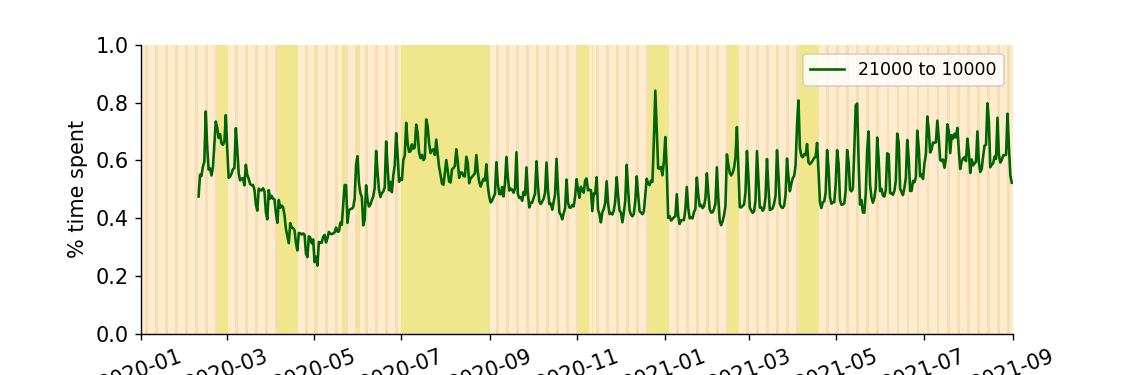

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


(array([18262., 18322., 18383., 18444., 18506., 18567., 18628., 18687.,
        18748., 18809., 18871.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [40]:
start_date = datetime.datetime(2020, 1, 1, 0, 0)
end_date = datetime.datetime(2021, 9, 1, 0, 0)
start_calibration_wave1 = pd.Timestamp(2020, 3, 5, 0, 0)
end_calibration_wave1 = pd.Timestamp(2020, 8, 7, 0, 0)
start_calibration_wave2 = pd.Timestamp(2020, 9, 1, 0, 0)
end_calibration_wave2 = pd.Timestamp(2021, 2, 1, 0, 0)

fig, ax = plt.subplots(figsize=(9,3))
ax.grid(False)
ax.set_xlim(start_date, end_date)
ymin, ymax = (0, 1)
ax.set_ylim(ymin, ymax)
color_timeframes(start_date, end_date, ax=ax)
# ax.set_title('test', size=14)

# Add shading denoting calibration periods
arrows = False
if arrows:
    label_cal_size = 9
    label_cal_move_up = (ymax-ymin)*0.015
    arrow_height = ymax
    ax.annotate(s='', xy=(start_calibration_wave1,arrow_height), xytext=(end_calibration_wave1,arrow_height), \
                arrowprops=dict(arrowstyle='<->'))
    label_cal1_move_right = 44 # days
    ax.text(start_calibration_wave1 + pd.Timedelta(days=label_cal1_move_right), \
            ymax + label_cal_move_up, 'calibration wave 1', size=label_cal_size)

    ax.annotate(s='', xy=(start_calibration_wave2,arrow_height), xytext=(end_calibration_wave2,arrow_height), \
                arrowprops=dict(arrowstyle='<->'))
    label_cal2_move_right = 41 # days
    ax.text(start_calibration_wave2 + pd.Timedelta(days=label_cal2_move_right), \
            ymax + label_cal_move_up, 'calibration wave 2', size=label_cal_size)

ticklabelsize = 12
plt.setp(ax.get_xticklabels(), Fontsize=ticklabelsize)
plt.setp(ax.get_yticklabels(), Fontsize=ticklabelsize)

plt.xticks(rotation=20)

In [41]:
# First load the data and inspect the mobility for this date range

filename = 'fractional-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/fractional/'

dates_proximus=[]
dates_proximus_datetime=[]

# Define date range
# sdate_prelockdown = datetime(2020, 2, 10, 0, 0)   # start date
# edate_prelockdown = datetime(2020, 3, 15, 0, 0)   # end date
delta = end_date - start_date     # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = start_date + datetime.timedelta(days=i)
    dates_proximus_datetime.append(day)
    dates_proximus.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox, missing_dates = load_Pmatrix_staytime(dates_proximus, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_proximus_xaxis = dates_proximus_datetime.copy()
for d in missing_dates:
    dates_proximus_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 567 dates.
Loaded dataframe for date 20210831.    


In [42]:
NIS_from = 21000
NIS_to = 10000
fractions = []
for key in mmprox:
    fractions.append(mmprox[key].loc[str(NIS_from), str(NIS_to)])
    
ax.plot(np.array(dates_proximus_xaxis)+datetime.timedelta(days=0.5), 100*np.array(fractions), color='darkgreen', linewidth=1.5, label=f'{NIS_from} to {NIS_to}')
ax.set_ylabel('% time spent', size=ticklabelsize)
ax.legend(fontsize = ticklabelsize-2, loc='upper right')#, bbox_to_anchor=(0.27, 1))

plt.savefig(f'proximus_time-spent_{NIS_from}-to-{NIS_to}.png', dpi=400, bbox_inches='tight')

**Add hospitalisations**

In [5]:
# Import Sciensano data
from covid19model.data.sciensano import get_sciensano_COVID19_data_spatial, get_sciensano_COVID19_data
# sciensano_df = get_sciensano_COVID19_data_spatial(agg='arr', values='hospitalised_IN', moving_avg=True).sum(axis=1)
sciensano_df = get_sciensano_COVID19_data(update=False)['H_in']
sciensano_values= sciensano_df.values
sciensano_dates = sciensano_df.index

ax2=ax.twinx()
ax2.grid(False)
ax2.plot(sciensano_dates, sciensano_values, linewidth=2, color='maroon', alpha=0.7, label='national')
ax2.set_ylabel('new daily hospitalisations', size=ticklabelsize)

# ax2.legend(fontsize = ticklabelsize-2, loc='upper right', bbox_to_anchor=(1, 0.90))

# plt.savefig(f'proximus_time-spent_{NIS_from}-to-{NIS_to}_with-hospitalisations.png', dpi=400, bbox_inches='tight')

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


In [49]:
get_sciensano_COVID19_data?